In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM,Dense,Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.dates as mdates
from sklearn import linear_model

In [3]:
df = pd.read_csv("RELIANCE.csv",na_values=['null'],index_col='Date',parse_dates=True,infer_datetime_format=True)
df.head()

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble,Date.1
Date,,,,,,,,,,,,,,,
2008-12-05,RELIANCE,EQ,1159.10,1175.0,1182.0,1103.00,1120.05,1117.60,1139.02,6679613,7.608186e+14,NaN,889986,0.1332,2008-12-05
2008-12-08,RELIANCE,EQ,1117.60,1152.2,1174.7,1107.00,1117.25,1118.55,1144.04,6965801,7.969165e+14,NaN,1751139,0.2514,2008-12-08
2008-12-10,RELIANCE,EQ,1118.55,1148.7,1234.0,1137.00,1223.00,1227.20,1188.02,7518930,8.932654e+14,NaN,1991852,0.2649,2008-12-10
2008-12-11,RELIANCE,EQ,1227.20,1250.0,1297.7,1193.30,1291.15,1259.00,1225.85,9088095,1.114063e+15,NaN,2517155,0.2770,2008-12-11
2008-12-12,RELIANCE,EQ,1259.00,1240.0,1324.0,1206.25,1310.20,1307.10,1273.48,9928592,1.264385e+15,NaN,2128688,0.2144,2008-12-12


In [4]:
columns=['Open', 'High', 'Low', 'Close', 'VWAP', 'Volume']

In [5]:
df_final= df[columns]
df_final.tail()

,Open,High,Low,Close,VWAP,Volume
Date,,,,,,
2019-11-08,1449.00,1459.65,1441.30,1445.50,1448.50,5494844
2019-11-11,1439.10,1444.25,1422.55,1427.80,1431.40,5192423
2019-11-13,1430.00,1475.90,1430.00,1472.30,1460.74,11532364
2019-11-14,1476.00,1481.60,1455.80,1462.75,1466.92,6518339
2019-11-15,1465.65,1486.80,1463.15,1470.85,1476.84,7173674


In [6]:
df_final.describe()

,Open,High,Low,Close,VWAP,Volume
count,2710.000000,2710.000000,2710.000000,2710.000000,2710.000000,2.710000e+03
mean,1061.642565,1074.778561,1047.887897,1060.750904,1061.325845,4.762714e+06
std,303.228074,309.570366,296.374499,302.737295,302.671508,3.226612e+06
min,675.000000,682.800000,673.050000,676.100000,676.940000,5.282000e+04
25%,872.925000,882.862500,861.437500,872.450000,872.192500,2.814556e+06
50%,987.100000,996.300000,976.900000,985.875000,986.830000,3.947585e+06
75%,1107.712500,1122.750000,1092.075000,1105.000000,1107.562500,5.718546e+06
max,2450.000000,2535.000000,2305.250000,2367.550000,2355.290000,4.792344e+07


In [7]:
df_final.isnull().values.any()

False

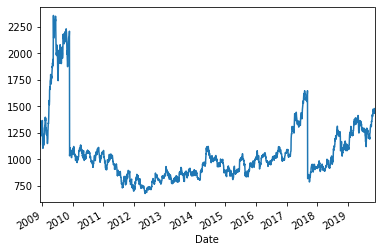

In [8]:
df_final['VWAP'].plot()

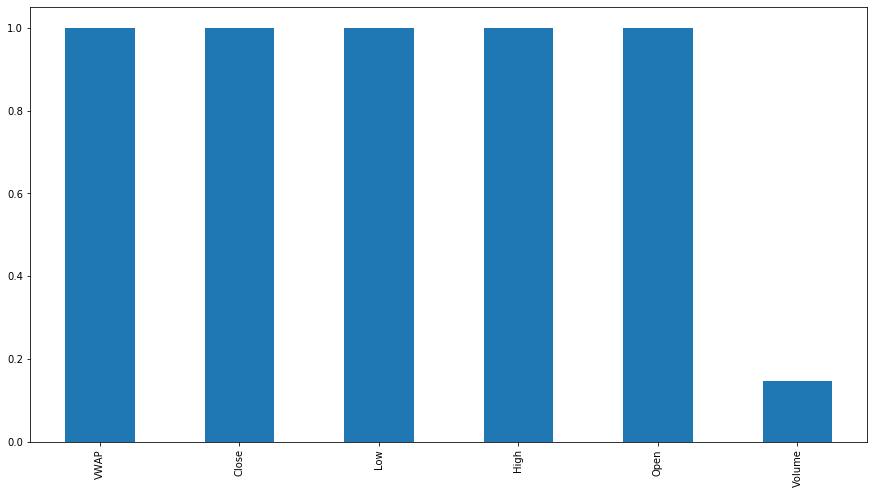

In [9]:
# Plotting Correlation of "Churn" with predictors
plt.figure(figsize=(15,8))
df_final.corr()['VWAP'].sort_values(ascending = False).plot(kind='bar')

In [10]:
test = df_final
# Target column
target = pd.DataFrame(test['VWAP'])
test.head()

,Open,High,Low,Close,VWAP,Volume
Date,,,,,,
2008-12-05,1175.0,1182.0,1103.00,1117.60,1139.02,6679613
2008-12-08,1152.2,1174.7,1107.00,1118.55,1144.04,6965801
2008-12-10,1148.7,1234.0,1137.00,1227.20,1188.02,7518930
2008-12-11,1250.0,1297.7,1193.30,1259.00,1225.85,9088095
2008-12-12,1240.0,1324.0,1206.25,1307.10,1273.48,9928592


In [11]:
# selecting Feature Columns
feature_columns = ['Open', 'High', 'Low', 'Close', 'Volume']

In [12]:
scaler = MinMaxScaler()
feature_minmax_transform_data = scaler.fit_transform(test[feature_columns])
feature_minmax_transform = pd.DataFrame(columns=feature_columns, data=feature_minmax_transform_data, index=test.index)
feature_minmax_transform.head()

,Open,High,Low,Close,Volume
Date,,,,,
2008-12-05,0.281690,0.269517,0.263417,0.261019,0.138431
2008-12-08,0.268845,0.265576,0.265868,0.261580,0.144410
2008-12-10,0.266873,0.297592,0.284248,0.325815,0.155964
2008-12-11,0.323944,0.331984,0.318742,0.344616,0.188744
2008-12-12,0.318310,0.346183,0.326676,0.373053,0.206301


In [13]:
print('Shape of features : ', feature_minmax_transform.shape)
print('Shape of target : ', target.shape)

Shape of features :  (2710, 5)
Shape of target :  (2710, 1)


In [14]:
# Shift target array because we want to predict the n + 1 day value
target = target.shift(-1)
validation_y = target[-90:-1]
target = target[:-90]

In [15]:
# Taking last 90 rows of data to be validation set
validation_X = feature_minmax_transform[-90:-1]
feature_minmax_transform = feature_minmax_transform[:-90]
display(validation_X.tail())
display(validation_y.tail())

,Open,High,Low,Close,Volume
Date,,,,,
2019-11-07,0.428169,0.421229,0.465108,0.462621,0.133400
2019-11-08,0.436056,0.419420,0.470684,0.454876,0.113682
2019-11-11,0.430479,0.411106,0.459196,0.444412,0.107364
2019-11-13,0.425352,0.428193,0.463761,0.470720,0.239804
2019-11-14,0.451268,0.431271,0.479567,0.465074,0.135062


,VWAP
Date,
2019-11-07,1448.50
2019-11-08,1431.40
2019-11-11,1460.74
2019-11-13,1466.92
2019-11-14,1476.84


In [16]:
print("\n -----After process------ \n")
print('Shape of features : ', feature_minmax_transform.shape)
print('Shape of target : ', target.shape)
display(target.tail())


 -----After process------ 

Shape of features :  (2620, 5)
Shape of target :  (2620, 1)


,VWAP
Date,
2019-06-26,1281.11
2019-06-27,1261.89
2019-06-28,1263.04
2019-07-01,1272.92
2019-07-02,1281.62


In [17]:
ts_split= TimeSeriesSplit(n_splits=10)
for train_index, test_index in ts_split.split(feature_minmax_transform):
        X_train, X_test = feature_minmax_transform[:len(train_index)], feature_minmax_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = target[:len(train_index)].values.ravel(), target[len(train_index): (len(train_index)+len(test_index))].values.ravel()

In [18]:
X_train.shape

(2382, 5)

In [19]:
X_test.shape

(238, 5)

In [20]:
y_train.shape

(2382,)

In [21]:
y_test.shape

(238,)

In [22]:
def validate_result(model, model_name):
    predicted = model.predict(validation_X)
    RSME_score = np.sqrt(mean_squared_error(validation_y, predicted))
    print('RMSE: ', RSME_score)
    
    R2_score = r2_score(validation_y, predicted)
    print('R2 score: ', R2_score)

    plt.plot(validation_y.index, predicted,'r', label='Predict')
    plt.plot(validation_y.index, validation_y,'b', label='Actual')
    plt.ylabel('Price')
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    
    plt.title(model_name + ' Predict vs Actual')
    plt.legend(loc='upper right')
    plt.show()

In [23]:
X_train =np.array(X_train)
X_test =np.array(X_test)

X_tr_t = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_tst_t = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [32]:
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model
from keras.layers import LSTM

K.clear_session()

model_lstm = Sequential()
model_lstm.add(LSTM(16, input_shape=(1, X_train.shape[1]), activation='relu', return_sequences=False))
model_lstm.add(Dense(1))

model_lstm.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)


history_model_lstm = model_lstm.fit(X_tr_t, y_train, epochs=200, batch_size=8, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/100
2382/2382 [==============================] - 2s 889us/step - loss: 1170909.9528
Epoch 2/100
2382/2382 [==============================] - 2s 741us/step - loss: 1163197.3020
Epoch 3/100
2382/2382 [==============================] - 2s 964us/step - loss: 1144772.9581
Epoch 4/100
2382/2382 [==============================] - 2s 951us/step - loss: 1112852.6051
Epoch 5/100
2382/2382 [==============================] - 2s 964us/step - loss: 1072285.9127
Epoch 6/100
2382/2382 [==============================] - 2s 991us/step - loss: 1027906.9074
Epoch 7/100
2382/2382 [==============================] - 2s 932us/step - loss: 979759.7513
Epoch 8/100
2382/2382 [==============================] - 2s 971us/step - loss: 928328.8917
Epoch 9/100
2382/2382 [==============================] - 2s 964us/step - loss: 874248.5241
Epoch 10/100
2382/2382 [==============================] - 2s 925us/step - loss: 818208.9010
Epoch 11/100
2382/2382 [==============================] - 2s 932us/step - loss: 760

2382/2382 [==============================] - 3s 1ms/step - loss: 1471.1529
Epoch 92/100
2382/2382 [==============================] - 3s 1ms/step - loss: 1463.0661
Epoch 93/100
2382/2382 [==============================] - 2s 1ms/step - loss: 1455.1568
Epoch 94/100
2382/2382 [==============================] - 2s 1ms/step - loss: 1447.4219
Epoch 95/100
2382/2382 [==============================] - 3s 1ms/step - loss: 1439.8629
Epoch 96/100
2382/2382 [==============================] - 2s 991us/step - loss: 1432.4761
Epoch 97/100
2382/2382 [==============================] - 2s 966us/step - loss: 1425.2616
Epoch 98/100
2382/2382 [==============================] - 2s 991us/step - loss: 1418.2185
Epoch 99/100
2382/2382 [==============================] - 3s 1ms/step - loss: 1411.3430
Epoch 100/100
2382/2382 [==============================] - 3s 1ms/step - loss: 1404.6372


In [33]:
y_pred_test_lstm = model_lstm.predict(X_tst_t)
y_train_pred_lstm = model_lstm.predict(X_tr_t)

print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_lstm)))
r2_train = r2_score(y_train, y_train_pred_lstm)

print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))
r2_test = r2_score(y_test, y_pred_test_lstm)

The R2 score on the Train set is:	0.986
The R2 score on the Test set is:	0.860


In [35]:
score_lstm= model_lstm.evaluate(X_tst_t, y_test, batch_size=1, verbose=0)
print('LSTM: %f'%score_lstm)

LSTM: 1335.305013


In [36]:
y_pred_test_LSTM = model_lstm.predict(X_tst_t)

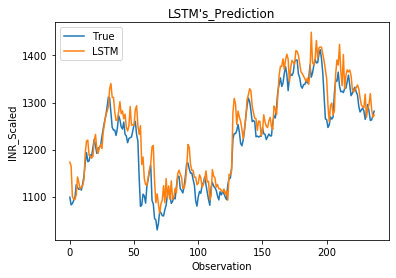

In [37]:
plt.plot(y_test, label='True')
plt.plot(y_pred_test_LSTM, label='LSTM')
plt.title("LSTM's_Prediction")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()

In [29]:
col1 = pd.DataFrame(y_test, columns=['True'])

col2 = pd.DataFrame(y_pred_test_LSTM, columns=['LSTM_prediction'])

col3 = pd.DataFrame(history_model_lstm.history['loss'], columns=['Loss_LSTM'])
results = pd.concat([col1, col2, col3], axis=1)
results.to_excel('PredictionResults_LSTM_NonShift.xlsx')